In [1]:
import numpy as np
import h5py

from timebudget import timebudget
import torch
import os
import time
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(font_scale=0.8)
%config InlineBackend.figure_format = 'retina'

In [2]:
class H5Dataset(Dataset):
    def __init__(self, filename, n_samples):
        self.f = h5py.File(filename, "r")
        self.n_samples = n_samples

    def __len__(self):
        return self.f["A"].shape[0] - self.n_samples

    def __getitem__(self, idx):
        return self.f["A"][idx : idx + self.n_samples, :, :]


T_size = 72000
J_size = 16
L_size = 60
A_size = (T_size, J_size, L_size)
chunk_size_list = [10, 100, 500, 1000, 2000, 4000, 10000]
read_times = []

for chunk_size in chunk_size_list:
    # delete the file if it exists
    filename = "datastore.h5"
    if os.path.exists(filename):
        os.remove(filename)

    with timebudget("writing data"):
        with h5py.File(filename, "a") as f:
            f_A = f.create_dataset(
                "A", shape=A_size, maxshape=A_size, dtype="float", chunks=(chunk_size, J_size, L_size)
            )
            f_A[:] = np.random.rand(*A_size)

    train_dataset = H5Dataset(filename="datastore.h5", n_samples=2000)
    samples_per_epoch = 400
    # defines random starting points
    subset_idx = np.random.choice(len(train_dataset), samples_per_epoch, replace=False)
    current_dataset = torch.utils.data.Subset(train_dataset, subset_idx)
    train_dataloader = DataLoader(current_dataset, batch_size=20, shuffle=True)

    start = time.time()
    for step, batch in enumerate(iter(train_dataloader)):
        pass
    end = time.time()
    read_times.append(end - start)

writing data took 1.251sec
writing data took 1.224sec
writing data took 1.292sec
writing data took 1.300sec
writing data took 1.314sec
writing data took 1.329sec
writing data took 1.746sec


[]

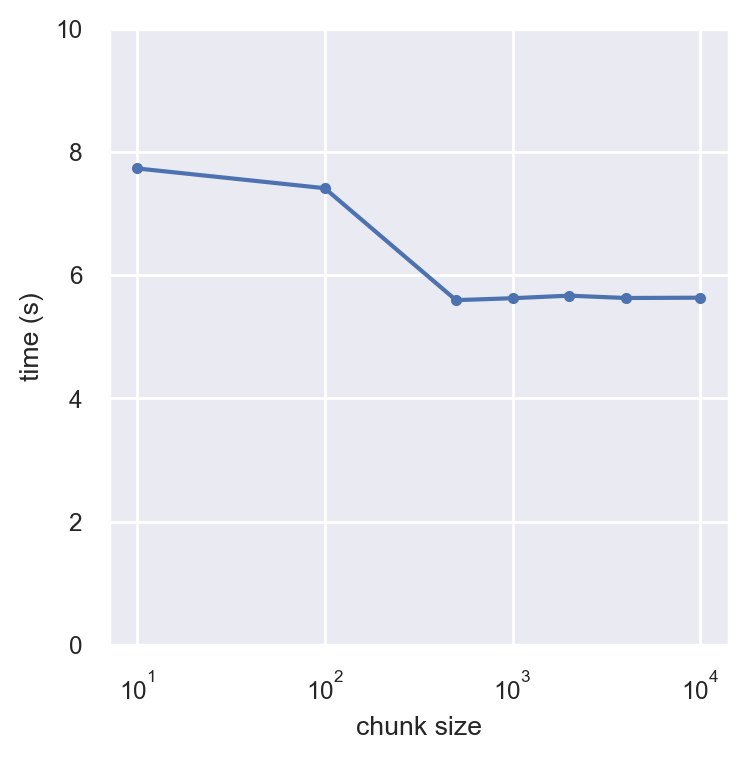

In [3]:
f, ax = plt.subplots(figsize=(4, 4))
ax.plot(chunk_size_list, read_times, ".-")
ax.set(xlabel="chunk size", ylabel="time (s)", ylim=(0, 10))
ax.set_xscale("log")
plt.plot()